# Group 14 - Project FP01
## Time series anomaly detection - RNN-EBM

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data, predict_anomaly_score
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve, plot_all_anomalies_over_time
from metrics import Confidence, anomaly_detection_metric, compute_metrics, compute_various_thresholds

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')

# transform in like collision
collisions['Timestamp'] = collisions_adjusted
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collision_rec5['Timestamp'] = collisions_adjusted_rec_5

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



In [5]:
# plot_signals(df, df_action, "Normal signals", saveplot=False)
# plot_signals(df_collision, df_action_collision, "Collision signals", saveplot=False)
# plot_signals(df_collision_1, df_action_collision_1, "Collision signals 1", saveplot=False)
# plot_signals(df_collision_5, df_action_collision_5, "Collision signals 5", saveplot=False)

### Features Exctraction

In [6]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 158.96926093101501 seconds ---


In [7]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

In [8]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_adjusted_rec_1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_adjusted_rec_5)

In [9]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

## RNN-EBM


In [10]:
from algorithms.rnn_ebm import RecurrentEBM

# Disable eager execution
tf.compat.v1.disable_eager_execution()

classifier = RecurrentEBM(
    num_epochs=100,
    n_hidden=64,
    n_hidden_recurrent=128,
    min_lr=1e-3,
    min_energy=None,  # We'll set this to None initially and determine it after training
    batch_size=32,
    seed=42,
    gpu=None  # Set to None for CPU, or specify GPU index if available
)
# Train the RNN on normal data
classifier.fit(X_train)
print("RNN-EBM training completed.")


100%|██████████| 100/100 [00:14<00:00,  7.13it/s]

RNN-EBM training completed.


In [11]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [12]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 7 with threshold 520.189208984375, std
Number of anomalies detected: 122 with threshold 35.15750312805176, mad
Number of anomalies detected: 16 with threshold 389.375, percentile
Number of anomalies detected: 15 with threshold 412.19001591205597, IQR

Number of anomalies detected: 8 with threshold 326.57033920288086, std
Number of anomalies detected: 51 with threshold 23.204442024230957, mad
Number of anomalies detected: 9 with threshold 255.82038574218743, percentile
Number of anomalies detected: 26 with threshold 64.0071132183075, IQR

Number of anomalies detected: 5 with threshold 481.3956604003906, std
Number of anomalies detected: 11 with threshold 433.8959045410156, mad
Number of anomalies detected: 8 with threshold 468.3992919921875, percentile
Number of anomalies detected: 3 with threshold 578.5446348190308, IQR



### Anomaly Detection

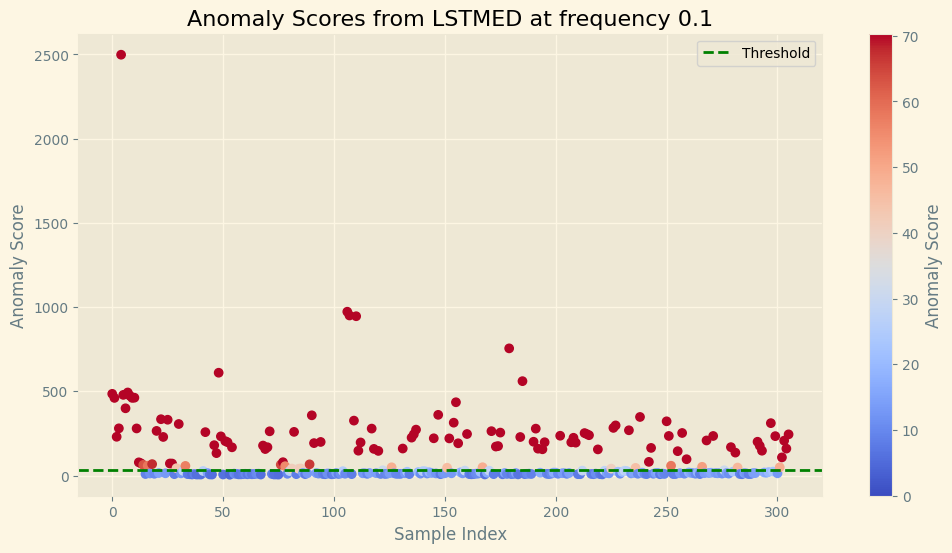

Number of anomalies detected: 122


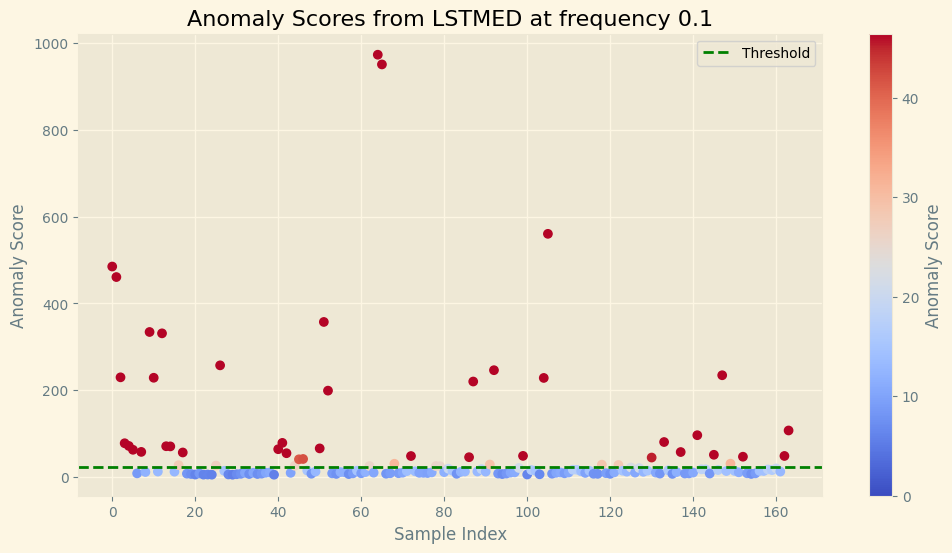

Number of anomalies detected: 51


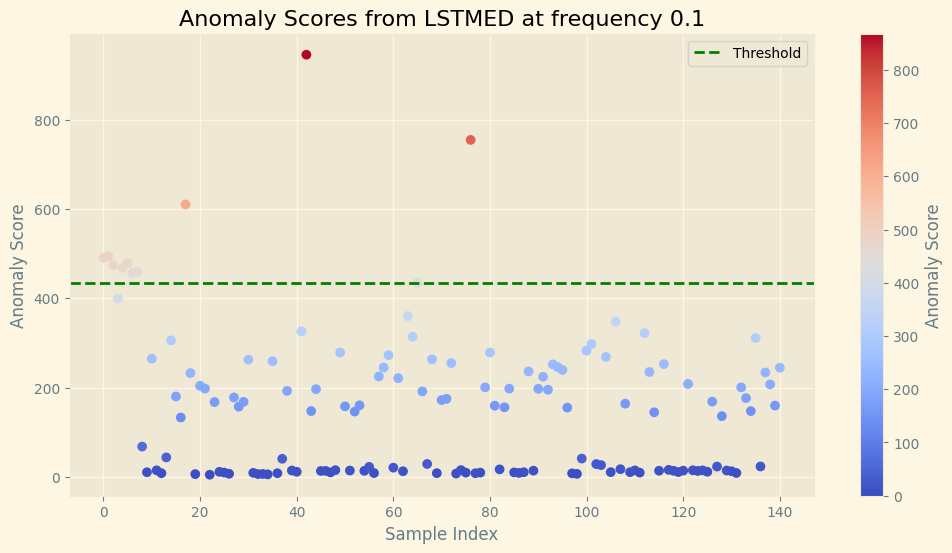

Number of anomalies detected: 11


In [13]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[1])

In [14]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 56)

In [15]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[1])

ROC AUC Score: 0.9433
Detected anomaly class: 1
Threshold: 35.1575
F1 Score: 0.9163
Accuracy: 0.9379
Precision: 0.8525
Recall: 0.9905
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       201
           1       0.85      0.99      0.92       105

    accuracy                           0.94       306
   macro avg       0.92      0.95      0.93       306
weighted avg       0.95      0.94      0.94       306

############################################
ROC AUC Score: 0.9710
Detected anomaly class: 1
Threshold: 23.2044
F1 Score: 0.8140
Accuracy: 0.9024
Precision: 0.6863
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       129
           1       0.69      1.00      0.81        35

    accuracy                           0.90       164
   macro avg       0.84      0.94      0.87       164
weighted avg       0.93      0.90      0.91       164

#################################

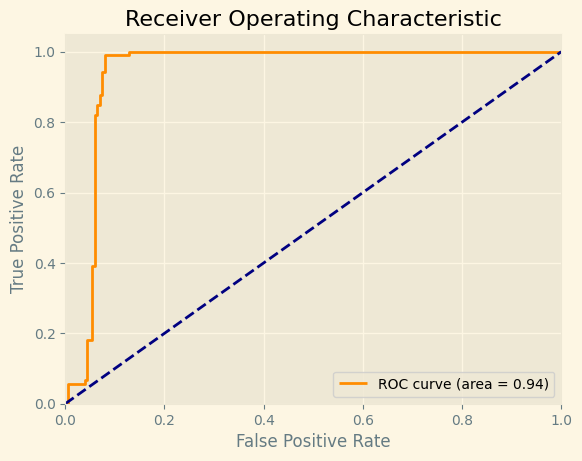

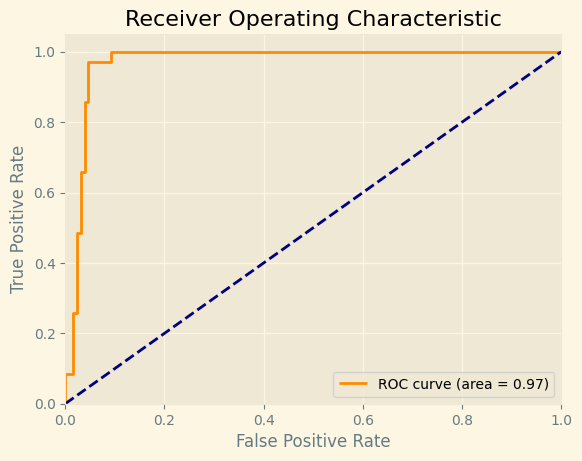

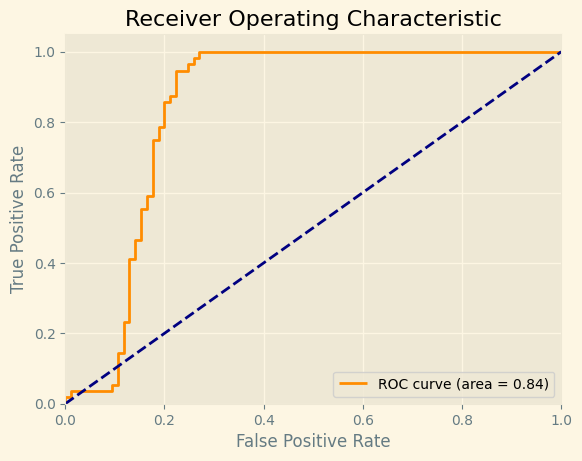

In [16]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

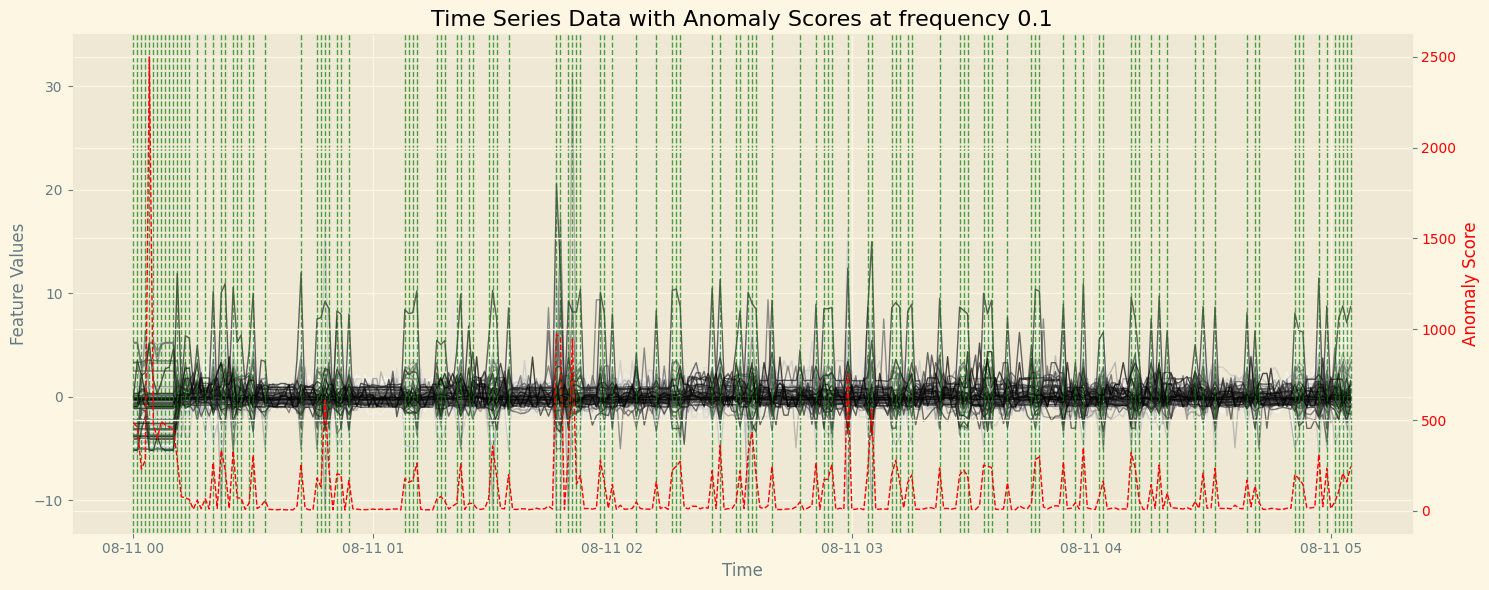

Top 122 Anomalies:
              timestamp  anomaly_score  \
4   2022-08-11 00:04:00    2498.123047   
106 2022-08-11 01:46:00     972.421448   
107 2022-08-11 01:47:00     950.076172   
110 2022-08-11 01:50:00     945.665344   
179 2022-08-11 02:59:00     754.827759   
..                  ...            ...   
29  2022-08-11 00:29:00      43.450066   
85  2022-08-11 01:25:00      42.011909   
81  2022-08-11 01:21:00      41.239582   
225 2022-08-11 03:45:00      40.873638   
84  2022-08-11 01:24:00      40.381645   

     machine_nameKuka Robot_apparent_power-_Average power  \
4                                            -5.323114      
106                                          -1.885449      
107                                          -1.181816      
110                                          -0.911260      
179                                          -1.338344      
..                                                 ...      
29                                           -0.5

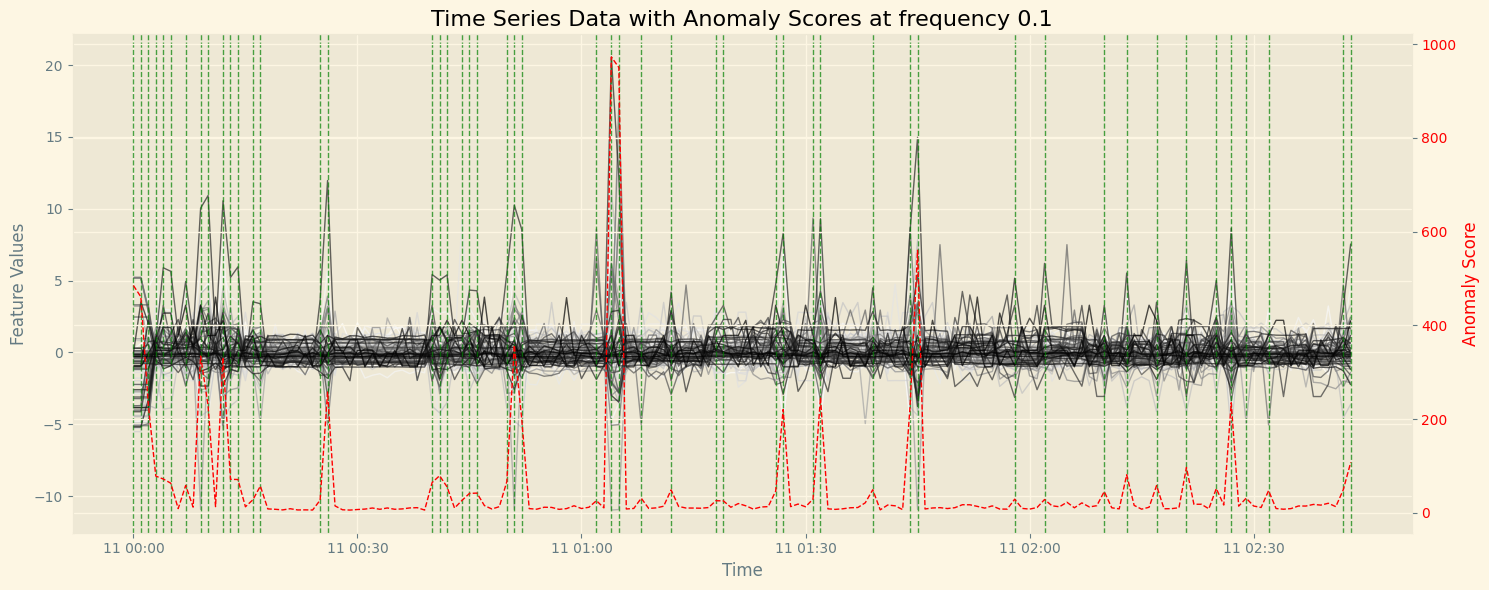

Top 51 Anomalies:
              timestamp  anomaly_score  \
64  2022-08-11 01:04:00     972.421448   
65  2022-08-11 01:05:00     950.076172   
105 2022-08-11 01:45:00     560.198059   
0   2022-08-11 00:00:00     484.919098   
1   2022-08-11 00:01:00     460.723083   
51  2022-08-11 00:51:00     357.378998   
9   2022-08-11 00:09:00     334.265869   
12  2022-08-11 00:12:00     331.157227   
26  2022-08-11 00:26:00     257.491791   
92  2022-08-11 01:32:00     246.349091   
147 2022-08-11 02:27:00     234.715271   
2   2022-08-11 00:02:00     229.913544   
10  2022-08-11 00:10:00     228.931854   
104 2022-08-11 01:44:00     228.532806   
87  2022-08-11 01:27:00     220.264526   
52  2022-08-11 00:52:00     199.282471   
163 2022-08-11 02:43:00     107.600792   
141 2022-08-11 02:21:00      96.712570   
133 2022-08-11 02:13:00      81.012222   
41  2022-08-11 00:41:00      79.043137   
3   2022-08-11 00:03:00      78.217529   
4   2022-08-11 00:04:00      72.023987   
13  2022-08-11 0

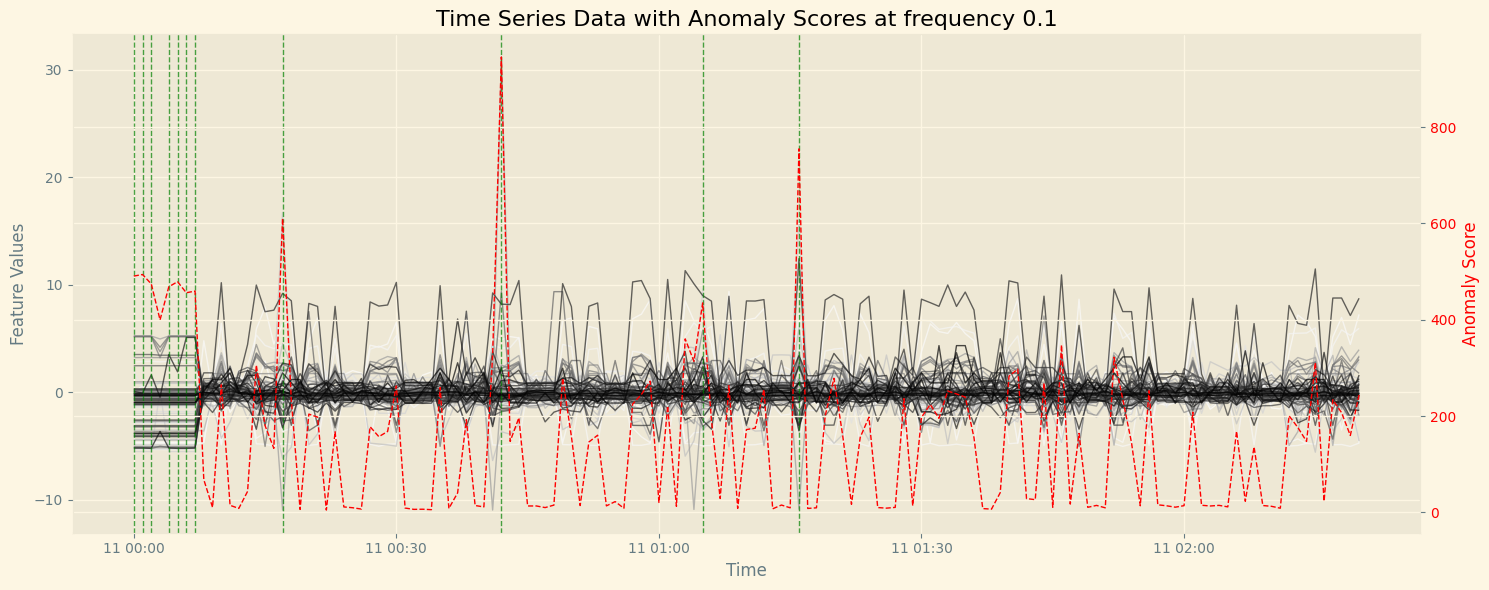

Top 11 Anomalies:
             timestamp  anomaly_score  \
42 2022-08-11 00:42:00     945.665344   
76 2022-08-11 01:16:00     754.827759   
17 2022-08-11 00:17:00     610.174805   
1  2022-08-11 00:01:00     493.925903   
0  2022-08-11 00:00:00     490.616211   
5  2022-08-11 00:05:00     478.948730   
2  2022-08-11 00:02:00     474.249542   
4  2022-08-11 00:04:00     468.399292   
7  2022-08-11 00:07:00     459.531677   
6  2022-08-11 00:06:00     455.969421   
65 2022-08-11 01:05:00     434.936523   

    machine_nameKuka Robot_apparent_power-_Average power  \
42                                          -0.911260      
76                                          -1.338344      
17                                          -0.707436      
1                                           -5.321892      
0                                           -5.315197      
5                                           -5.323855      
2                                           -5.322115      
4        

In [17]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)